In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_of_gpu = torch.cuda.device_count()
device, num_of_gpu

('cuda', 2)

# Get data

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [6]:
IMG_SIZE=224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manualy created transforms: {manual_transforms}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
type(manual_transforms)

torchvision.transforms.transforms.Compose

In [8]:
# Dataloader for images
BATCH_SIZE = 32  # Higher number of batch size, the more computation power is needed

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir, 
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd94a85f750>,
 ['pizza', 'steak', 'sushi'])

In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

![](./08-vit-paper-figure-1-inputs-and-outputs.png)

# Eq 1: Split the data into patches, then creating the class, position, and patch embedding.   

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

```

### 1. Calculating patch embedding input and output shapes

In [10]:
# Create example values
height = 224        # height
width = 224         # width
color_channels = 3  # channel 
patch_size = 16     # P

# Calculate N (num of patches)
num_of_patches = int((height * width) / patch_size**2)
print(f'Num of patch (N) with image height (G={height}), width (W={width}), and patch size (P={patch_size}): {num_of_patches} ')


Num of patch (N) with image height (G=224), width (W=224), and patch size (P=16): 196 


In [11]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f'input: {embedding_layer_input_shape}')
print(f'output: {embedding_layer_output_shape}')

input: (224, 224, 3)
output: (196, 768)


### 2. Convert an image into patches 

(-0.5, 223.5, 223.5, -0.5)

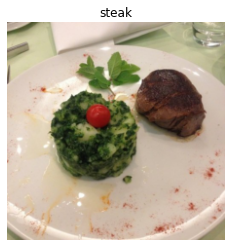

In [12]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

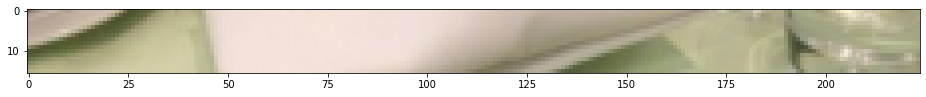

In [13]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

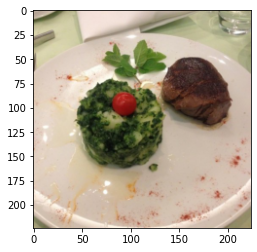

In [14]:
plt.imshow(image_permuted)

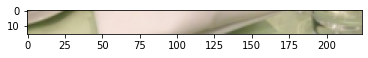

In [15]:
plt.imshow(image_permuted[:16, :, :])

Num of patches per row: 14.0
Patch size: 16 * 16


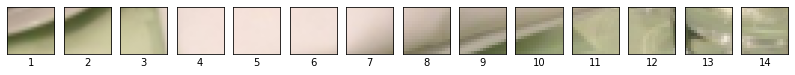

In [16]:
# Setup hyperparameters and make sure image_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patchs = img_size / patch_size
assert img_size % patch_size == 0
print(f'Num of patches per row: {num_patchs}\nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patchs, num_patchs),
                        sharex=True,
                        sharey=True)

# Iterate through num of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Num of patches per row: 14.0        
Num of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 * 16


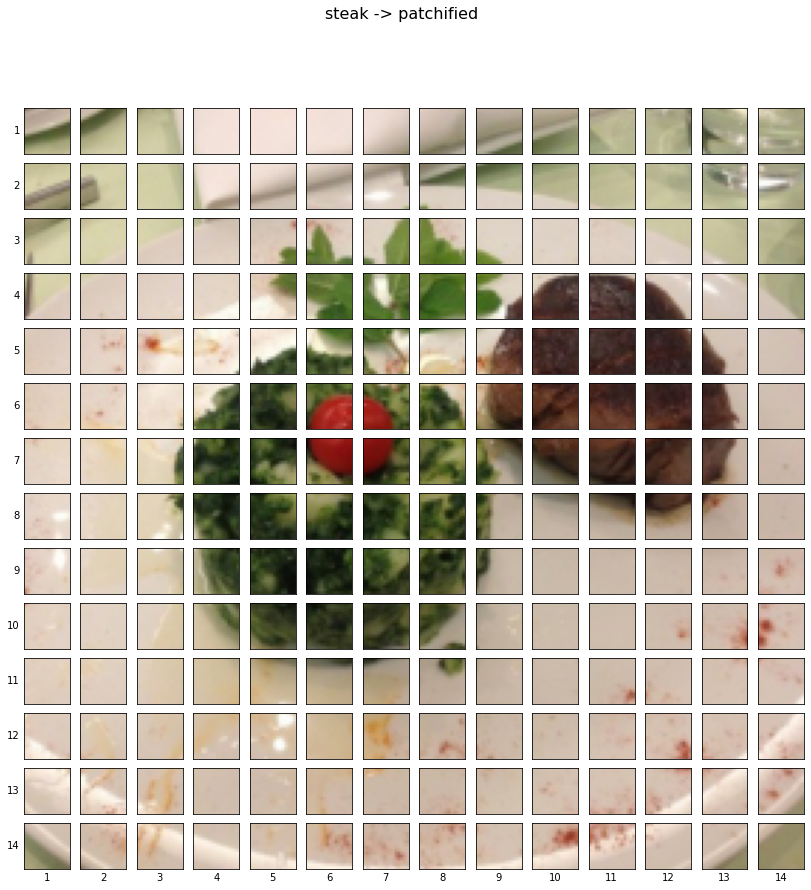

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f'Num of patches per row: {num_patches}\
        \nNum of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} * {patch_size}')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of img
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted img patch (img_permuted ->(height, width, channel))
        axs[i, j].imshow(image_permuted[patch_height: patch_height+patch_size,
                                        patch_width: patch_width+patch_size,
                                        :])
        
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=16)
plt.show()

### 3. Creating image patches with torch.nn.Conv2d() 
*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding*


**input**: $H * W * C$   
**2D img**: (224,224,3)->(height, width, colorChannels)

**output**: $N * \bigg(P^2 \cdot  C \bigg)$
**flattened 2d patches**: (192,768)->(num of patches, embedding dims)

`torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.   
`torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

In [18]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,    # num of color-channels
                   out_channels=768, # embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

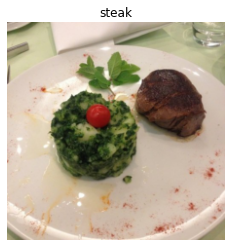

In [19]:
# view the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [20]:
# pass the img through the cnn 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dim
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [21]:
image.shape

torch.Size([3, 224, 224])

In [22]:
# # Plot random 5 convolutional feature maps

# import random
# random_indexes = random.sample(range(0, 758), k=5)
# print(f"howing random convolutinal feature maps from indexes: {random_indexes}")

# # Create plot
# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# # plot random image feature maps
# for i, idx in enumerate(random_indexes):
#     image_conv_feature_map = image_out_of_conv[:, idx, :, :]
# #     axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
#     axs[i].imshow(image_conv_feature_map.squeeze())
#     axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

howing random convolutinal feature maps from indexes: [200, 660, 522, 714, 500]


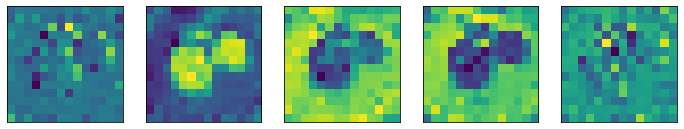

In [23]:
# Plot random 5 convolutional feature maps

import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"howing random convolutinal feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [24]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[ 0.3245,  0.4042,  0.3762,  0.4049,  0.3984,  0.3915,  0.2691,
           0.1587,  0.3450,  0.2172,  0.3333,  0.2289,  0.4456,  0.2746],
         [ 0.2190,  0.3899,  0.3285,  0.3255,  0.2839,  0.4010,  0.3155,
           0.4337,  0.3689,  0.3733,  0.3380,  0.3171,  0.3131,  0.2800],
         [ 0.3889,  0.3857,  0.3641,  0.3684,  0.2161,  0.4545,  0.0711,
           0.3981,  0.3711,  0.3659,  0.3510,  0.3327,  0.3136,  0.2399],
         [ 0.4822,  0.3749,  0.3777,  0.4089,  0.3097,  0.1256,  0.1455,
           0.1408,  0.4579,  0.0130,  0.1629,  0.4704,  0.3164,  0.2412],
         [ 0.3828,  0.3760,  0.4311,  0.3965, -0.1832, -0.0224,  0.2982,
           0.3507,  0.0977,  0.1318,  0.1358,  0.1548,  0.4053,  0.3277],
         [ 0.3897,  0.4012,  0.3845, -0.0888,  0.1165,  0.2650,  0.2564,
           0.1841,  0.0211,  0.2256,  0.1677,  0.1653,  0.3519,  0.3486],
         [ 0.3904,  0.3882,  0.2184,  0.0757,  0.3149,  0.2058,  0.1547,
           0.2003,  0.2590,  0.1385,  0.1143,

In [25]:
single_feature_map.requires_grad

True

### 4. Flattening the patch embedding 
`torch.nn.Flatten()`

In [26]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding, map_height, map_width,]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding, map_height, map_width,]


In [27]:
# current tensor shape -> [1,768,14,14]
# start_dim=2 -> [1,768, 14*, 14]
# end_dim=3 -> [1,768, 14, 14*]

flattened = nn.Flatten(start_dim=2,   # flatten feature_map_height (dim2)
                       end_dim=3)     # flatten feature_map_width (dim3)

### Put all together

Original image shape -> torch.Size([3, 224, 224])
potted image shape -> torch.Size([224, 224, 3])


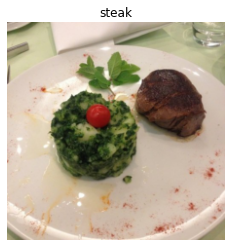

In [28]:
# 1. View a single image

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])
print(f"Original image shape -> {image.shape}")
print(f"potted image shape -> {image.permute(1,2,0).shape}")

In [29]:
# 2. Turn image into feature maps

image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dim to it
print(f"Image feature map shape -> {image_out_of_conv.shape}")

Image feature map shape -> torch.Size([1, 768, 14, 14])


In [30]:
# 3. Flatten the feature maps

image_out_of_conv_flattened = flattened(image_out_of_conv)
print(f"Flattened image feature map shape -> {image_out_of_conv_flattened.shape}")

Flattened image feature map shape -> torch.Size([1, 768, 196])


In [31]:
# Reshape the flattended feature maps -> the desired output feature maps
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape now -> {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape now -> torch.Size([1, 196, 768])


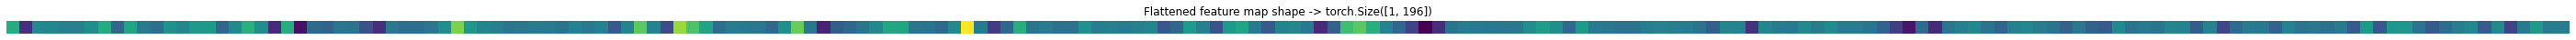

In [32]:
# Single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 150] # [batch, num_patches, embedding_dim]

# Plot the flattened feature map
plt.figure(figsize=(50,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape -> {single_flattened_feature_map.shape}")
plt.axis(False);

In [33]:
image_out_of_conv_flattened_reshaped[:, :, 1].shape

torch.Size([1, 196])

In [34]:
# for each in range(image_out_of_conv_flattened_reshaped.shape[2]):
#     single_flattened = image_out_of_conv_flattened_reshaped[:, :, each]
    
#     plt.figure(figsize=(22,22))
#     plt.imshow(single_flattened.detach().numpy())
#     plt.title(f"The {each} Flattened feature map")
#     plt.axis(False);
    
# plt.clf()

### 5. Turning the ViT patch embedding layer into a PyTorch module

In [35]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turning a 2D input image into a 1D sequence 
    learnable embedding vector.
    
    Args:
        in_channels(int): Num of color channels for the input imgs.
        Defaults to 3. 
        patch_size(int): Size of patches to convert input img into. 
        Defaults to 16.
        embedding_dim(int): Size of embedding to turn img inot. De
        faults to 768.
        
    """
    
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        
        
        # 3. Create a layer to turn an img into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # 4. Create a layer to flatten the patch feature maps into
        # a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
        # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are 
        # the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"img \
        size should be divisible by patch size, img shape -> \
        {image_resolution}, patch size -> {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)


        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)

In [36]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input img shape -> {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape -> {patch_embedded_image.shape}")

Input img shape -> torch.Size([1, 3, 224, 224])
Output patch embedding shape -> torch.Size([1, 196, 768])


In [37]:
# Create random input sizes
random_input_image = (1,3,224,224)
# random_input_image = (1,3,250,250)  # error-> incompatible with patchSize

# Get a summary of the input and outputs
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", \
                   "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 6. Creating the class token embedding

In [38]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"patch shape -> {patch_embedded_image.shape}")

tensor([[[-0.6465,  0.3099, -0.1044,  ...,  0.4933, -0.3835,  0.1215],
         [-0.5108,  0.1034, -0.2921,  ...,  0.4951, -0.2279,  0.2423],
         [-0.7797,  0.2552, -0.2461,  ...,  0.5228, -0.3470,  0.3273],
         ...,
         [-0.8023,  0.1899, -0.1956,  ...,  0.6232, -0.4175,  0.2981],
         [-0.7576,  0.1587, -0.1061,  ...,  0.4638, -0.3651,  0.2934],
         [-0.5107,  0.0642, -0.1332,  ...,  0.4363, -0.3659,  0.2201]]],
       grad_fn=<PermuteBackward0>)
patch shape -> torch.Size([1, 196, 768])


> patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)

In [39]:
# Get the batch size and embedding dims
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1] 

# Create the class token embedding as a learnable parameter 
# that shares the same size as the embedding dim (D)

cls_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                         requires_grad=True)

# Show the first 10 examples of the class token
print(cls_token[:, :, :10])

# Print the class token shape
print(f"Class token shape -> {cls_token.shape} -> [batch, num_of_tokens, embeddings]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape -> torch.Size([1, 1, 768]) -> [batch, num_of_tokens, embeddings]


In [40]:
# Add the cls token embedding to the front of the patch embedding
patch_embedded_image_with_cls_embedding = torch.cat((cls_token, patch_embedded_image),
                                                    dim=1)

# Print the sequence of patch embeddings with the prepended cls token embedding
print(patch_embedded_image_with_cls_embedding)
print(f"Sequence of patch embeddings with cls token prepended shape -> {patch_embedded_image_with_cls_embedding.shape}\n -> [batch, num_of_patch, embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6465,  0.3099, -0.1044,  ...,  0.4933, -0.3835,  0.1215],
         [-0.5108,  0.1034, -0.2921,  ...,  0.4951, -0.2279,  0.2423],
         ...,
         [-0.8023,  0.1899, -0.1956,  ...,  0.6232, -0.4175,  0.2981],
         [-0.7576,  0.1587, -0.1061,  ...,  0.4638, -0.3651,  0.2934],
         [-0.5107,  0.0642, -0.1332,  ...,  0.4363, -0.3659,  0.2201]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with cls token prepended shape -> torch.Size([1, 197, 768])
 -> [batch, num_of_patch, embedding_dim]


### 7. Creating the position embedding  
$$E_{pos} \in R ^{(N+1)\times D}$$  

* $N = HW/P^2 $  
* $D$ The size of the patch embeddings, in this calse 768

In [41]:
# View the sequence of patch embeddings with the prepended cls embedding
patch_embedded_image_with_cls_embedding, patch_embedded_image_with_cls_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6465,  0.3099, -0.1044,  ...,  0.4933, -0.3835,  0.1215],
          [-0.5108,  0.1034, -0.2921,  ...,  0.4951, -0.2279,  0.2423],
          ...,
          [-0.8023,  0.1899, -0.1956,  ...,  0.6232, -0.4175,  0.2981],
          [-0.7576,  0.1587, -0.1061,  ...,  0.4638, -0.3651,  0.2934],
          [-0.5107,  0.0642, -0.1332,  ...,  0.4363, -0.3659,  0.2201]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [42]:
# Calculate N(num of patches)
num_of_patches = int((height * width) / patch_size**2)

# Get embedding dim
embedding_dim = patch_embedded_image_with_cls_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             num_of_patches+1,
                                             embedding_dim),
                                 requires_grad=True)

# Show the first 10 sequences and 10m position embedding values and check the shape 
# of position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape -> {position_embedding.shape} -> [batch, num_of_patches, embedding_dim]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape -> torch.Size([1, 197, 768]) -> [batch, num_of_patches, embedding_dim]


In [43]:
# Add the cls token and position embedding 
cls_and_position_embedding = patch_embedded_image_with_cls_embedding + position_embedding
print(cls_and_position_embedding)
print(f"Full embedding shape -> {cls_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3535, 1.3099, 0.8956,  ..., 1.4933, 0.6165, 1.1215],
         [0.4892, 1.1034, 0.7079,  ..., 1.4951, 0.7721, 1.2423],
         ...,
         [0.1977, 1.1899, 0.8044,  ..., 1.6232, 0.5825, 1.2981],
         [0.2424, 1.1587, 0.8939,  ..., 1.4638, 0.6349, 1.2934],
         [0.4893, 1.0642, 0.8668,  ..., 1.4363, 0.6341, 1.2201]]],
       grad_fn=<AddBackward0>)
Full embedding shape -> torch.Size([1, 197, 768])


### 8. Put all together

In [44]:
set_seeds()  # helper function

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the img dims
print(f"Original image shape -> {image.shape}")
height, width = image.shape[1], image.shape[2]

print(f"Original image height, and width -> {height, width}")

# 3. Get image tensor and add batch dim
x = image.unsqueeze(0)
print(f"image with batch dim -> {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape -> {patch_embedding.shape}")

# 6. Create cls token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
cls_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                         requires_grad=True)
print(f"Cls token embedding shape -> {cls_token.shape}")

# 7. Prepend cls token embedding to patch embedding
patch_embedding_cls_token = torch.cat((cls_token, patch_embedding), dim=1)
print(f"patch embedding with cls token -> {patch_embedding_cls_token.shape}")

# 8. Create position embedding
num_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1,  embedding_dim),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with cls token
patch_and_position_embedding = patch_embedding_cls_token + position_embedding
print(f"Full embedding shape -> {patch_and_position_embedding.shape}")

Original image shape -> torch.Size([3, 224, 224])
Original image height, and width -> (224, 224)
image with batch dim -> torch.Size([1, 3, 224, 224])
Patching embedding shape -> torch.Size([1, 196, 768])
Cls token embedding shape -> torch.Size([1, 1, 768])
patch embedding with cls token -> torch.Size([1, 197, 768])
Full embedding shape -> torch.Size([1, 197, 768])


![](./08-vit-paper-architecture-animation-full-architecture.gif)

# Eq 2 -> Multi-Head Attenton
- torch.nn.MultiheadAttention()
    - `embed_dim`
    - `num_heads`
    - `dropout`
    - `batch_first`
- torch.n.LayerNorm()
- Residual connection

In [45]:
# 1. Creae a cls that inherits from nn.Module
class MultiheadSelfAttentionBlk(nn.Module):
    """
    Creates a multi-head self-attention block -> MSA
    """
    
    # 2. Initialzie the cls with hyperparameters
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads:     int=12,
                 attn_dropout:  float=0):
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [46]:
# Create an instance of MSABlk
multihead_self_attention_blk = MultiheadSelfAttentionBlk(embedding_dim=768,
                                                         num_heads=12)

# Pass patch and position img embedding through MSABlk
patched_img_through_msa_blk = multihead_self_attention_blk(patch_and_position_embedding)
print(f"Input -> {patch_and_position_embedding.shape}")
print(f"Output -> {patched_img_through_msa_blk.shape}")

Input -> torch.Size([1, 197, 768])
Output -> torch.Size([1, 197, 768])


# Eq3: Multilayer Perception
- `torch.nn.Linear()`
- `torch.nn.GELU()`
- `torch.nn.Dropout()`

In [47]:
# 1. Create a cls that inherits from nn.Module
class MLPBlk(nn.Module):
    """
    Creates a layer normalized multiplayer perceptron blk 
    """
    
    # 2. Initialize the cls with hyperparameters
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=.1):
        super().__init__()
        
        # 3. Create the norm layer
        # Notice the layer normalization tends to manipulate the data
        # along channel compares to batch normalization which it normalizes the data
        # along the batch of data with each individual channel data
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    # 5. Create a forward method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [48]:
# Instance of MLPBlk
mlp_blk = MLPBlk(embedding_dim=768,
                 mlp_size=3072,
                 dropout=.1)

# Pass output of MSABlk through MLPBlk
patched_img_through_mlp_blk = mlp_blk(patched_img_through_msa_blk)
print(f"Input shape -> {patched_img_through_msa_blk.shape}")
print(f"Output shape -> {patched_img_through_mlp_blk.shape}")

Input shape -> torch.Size([1, 197, 768])
Output shape -> torch.Size([1, 197, 768])


# Create the Transformer Encoder

In [49]:
# 1. Create a cls taht inherits from nn.Modules
class TransformerEncoderBlk(nn.Module):
    """
    Creates a Transformer Encoder blk
    """
    
    # 2. Initialize the cls with hyperparameters
    def __init__(self, 
                 embedding_dim:   int=768,
                 num_heads:       int=12,
                 mlp_size:        int=3072,
                 mlp_dropout:     float=.1,
                 attn_dropout:    float=0):
        super().__init__()
        
        # 3. Create MSA blk 
        self.msa_blk = MultiheadSelfAttentionBlk(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
        
        # 4. Create MLP blk
        self.mlp_blk = MLPBlk(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
        
    # 5. forward method
    def forward(self, x):
        
        # 6. Create residula connection for MSA blk (add the input to the output)
        x = self.msa_blk(x) + x
        
        # 7. Create residual connection for MLP blk (add the input to the output, notice the x here is the output of residual outcome from MSABlk)
        x = self.mlp_blk(x) + x
        
        return x

In [50]:
# Summary of TransformerEncoderBlk

transformer_encoder_blk = TransformerEncoderBlk()

summary(model=transformer_encoder_blk,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
#         row_settings=["var_names"])
        row_settings=["depth"])

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Trainable
TransformerEncoderBlk                    [1, 197, 768]      [1, 197, 768]      --                 True
├─MultiheadSelfAttentionBlk: 1-1         [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm: 2-1                    [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─MultiheadAttention: 2-2           --                 [1, 197, 768]      2,362,368          True
├─MLPBlk: 1-2                            [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm: 2-3                    [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─Sequential: 2-4                   [1, 197, 768]      [1, 197, 768]      --                 True
│    │    └─Linear: 3-1                  [1, 197, 768]      [1, 197, 3072]     2,362,368          True
│    │    └─GELU: 3-2                    [1, 197, 3072]     [1, 197,

In [51]:
# Summary of TransformerEncoderBlk

transformer_encoder_blk = TransformerEncoderBlk()

summary(model=transformer_encoder_blk,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"])
#         row_settings=["depth"])

Layer (type (var_name))                            Input Shape        Output Shape       Param #            Trainable
TransformerEncoderBlk (TransformerEncoderBlk)      [1, 197, 768]      [1, 197, 768]      --                 True
├─MultiheadSelfAttentionBlk (msa_blk)              [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─MultiheadAttention (multihead_attn)         --                 [1, 197, 768]      2,362,368          True
├─MLPBlk (mlp_blk)                                 [1, 197, 768]      [1, 197, 768]      --                 True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]      [1, 197, 768]      1,536              True
│    └─Sequential (mlp)                            [1, 197, 768]      [1, 197, 768]      --                 True
│    │    └─Linear (0)                             [1, 197, 768]      [1, 197, 3072]     2,

In [52]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformerEncoder = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

In [53]:
torch_transformerEncoder = nn.TransformerEncoderLayer(d_model=768,
                                                      nhead=12,
                                                      dim_feedforward=3072,
                                                      dropout=0.1,
                                                      activation='gelu')
#                                                       batch_first=True)
#                                                       norm_first=True) # Normalize first or after MSA/MLP layers?

In [54]:
summary(model=torch_transformerEncoder,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"])
#         row_settings=["depth"])

Layer (type (var_name))                            Input Shape        Output Shape       Param #            Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]      [1, 197, 768]      --                 True
├─MultiheadAttention (self_attn)                   [1, 197, 768]      [1, 197, 768]      2,362,368          True
├─Dropout (dropout1)                               [1, 197, 768]      [1, 197, 768]      --                 --
├─LayerNorm (norm1)                                [1, 197, 768]      [1, 197, 768]      1,536              True
├─Linear (linear1)                                 [1, 197, 768]      [1, 197, 3072]     2,362,368          True
├─Dropout (dropout)                                [1, 197, 3072]     [1, 197, 3072]     --                 --
├─Linear (linear2)                                 [1, 197, 3072]     [1, 197, 768]      2,360,064          True
├─Dropout (dropout2)                               [1, 197, 768]      [1, 197, 768]      --    

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [`torch.Tensor.expand()`](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Dance and shout woohoo!!! We just built a Vision Transformer!

In [55]:
# 1. Create a ViT cls that inherits from nn.Module
class ViT(nn.Module):
    """
    Creates a vision transformer architecture with ViT-Base hyperparameter
    """
    # 2. Initialization of the parameters
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=.1,
                 embedding_dropout:float=.1,
                 num_classes:int=1000):
        super().__init__()
        
        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0
        
        # 4. Calculate num of patches (height * width/ patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # 5. Create learnable class embedding 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blk (stacking of the Encoder blks -> nn.Sequential())
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlk(embedding_dim=embedding_dim,
                                                                         num_heads=num_heads,
                                                                         mlp_size=mlp_size,
                                                                         mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)
                                                  ]
                                                )
        
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
        
    # 11.Create a forward method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create cls token embedding and expand it to match the batch size
        cls_token = self.class_embedding.expand(batch_size, -1, -1)
        
        # 14. Create patch embedding
        x = self.patch_embedding(x)
        
        # 15. Concat cls embedding and patching embedding
        x = torch.cat((cls_token, x), dim=1)
        
        # 16. Add position embedding to patch embedding
        x = self.position_embedding + x
        
        # 17. Run embedding dropout
        x = self.embedding_dropout(x)
        
        # 18. Pass patch, position, and cls embedding through trans encoder layer
        x = self.transformer_encoder(x)
        
        # 19. Put 0 index logit through classifier
        x = self.classifier(x[:, 0])
        
        return x

In [56]:
# Test for cls embedding and expanding over a batch dim
batch_size = 32
cls_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))
cls_token_embedding_expanded = cls_token_embedding_single.expand(batch_size, -1, -1)

cls_token_embedding_single.shape, cls_token_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [57]:
# Pass a random example in the same shape as a single image to the custom ViT
set_seeds()

rand_img_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))

vit(rand_img_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [58]:
# Visual summary of the ViT model
from torchinfo import summary

summary(model=vit,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [32, 3, 224, 224] [32, 3]         152,064         True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224] [32, 196, 768]  --              True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                     [32, 768, 14, 14] [32, 768, 196]  --              --
├─Dropout (embedding_dropout)                                [32, 197, 768]  [32, 197, 768]  --              --
├─Sequential (transformer_encoder)                           [32, 197, 768]  [32, 197, 768]  --              True
│    └─TransformerEncoderBlk (0)                             [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─MultiheadSelfAttentionBlk (msa_blk)              [32, 197, 768]  

```python
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

```

In [59]:
# Training the ViT model
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters by using the hyperparameters
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(.9, .999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=.3
                            ) 

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the results
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7759 | train_acc: 0.3711 | test_loss: 4.9358 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.1708 | train_acc: 0.2891 | test_loss: 1.8335 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1926 | train_acc: 0.4414 | test_loss: 1.6165 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2510 | train_acc: 0.2891 | test_loss: 1.2894 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1610 | train_acc: 0.2930 | test_loss: 1.1510 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1835 | train_acc: 0.2812 | test_loss: 1.2352 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2748 | train_acc: 0.3086 | test_loss: 1.1199 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1050 | train_acc: 0.2812 | test_loss: 1.1898 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1505 | train_acc: 0.3047 | test_loss: 1.0172 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2623 | train_acc: 0.2617 | test_loss: 1.3942 | test_acc: 0.2604


In [60]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
    
    
train_ = datasets.ImageFolder(train_dir, transform=transforms.Compose)
print(len(train_))

print(len(train_dataloader.dataset))

225
225


| **Hyperparameter value**                                     | **ViT Paper**                                      | **Our implementation** |
| :----------------------------------------------------------- | :------------------------------------------------- | :--------------------- |
| Number of training images                                    | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225                    |
| Epochs                                                       | 7 (for largest dataset), 90, 300 (for ImageNet)    | 10                     |
| Batch size                                                   | 4096                                               | 32                     |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3)                                | None                   |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning rate decay is a,help both optimization and generalization.) | Linear/Cosine (Table 3)                            | None                   |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3)                            | None                   |





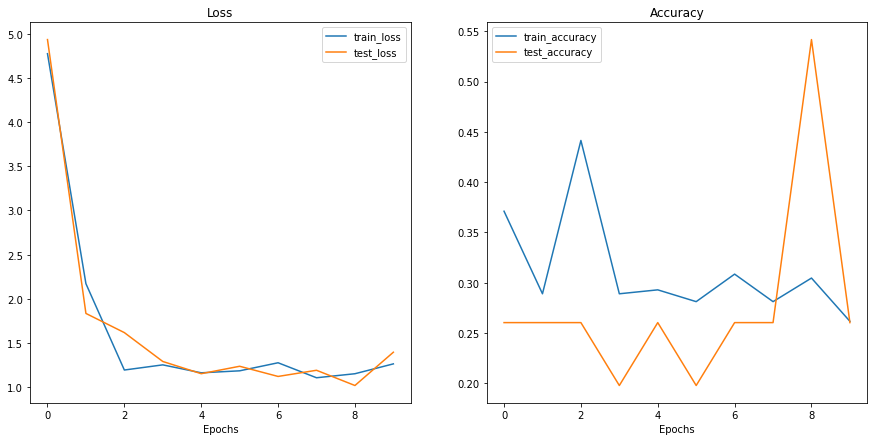

In [61]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Pre-trained ViT   
- from `torchvision.models`


In [62]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The current device is working on -> {device}")

The current device is working on -> cuda


In [64]:
# 1. Get pretrained weights fro ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
set_seeds()            # sets the seeds to ensure the same init with linear head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [65]:
# summary of the pretrained model
summary(model=pretrained_vit,
        input_size=(32,3,224,224),
#         col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 3]    768        Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)  False
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlo

In [66]:
# Preparing data for the pretrained ViT model

from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [67]:
# Setup train and test dir
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [68]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [69]:
# Dataloader
train_dataloader_pretrained, test_dataloader_pretrained, cls_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=pretrained_vit_transforms,
                                                                                                   batch_size=32)

In [70]:
# Train feature extractor ViT model
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


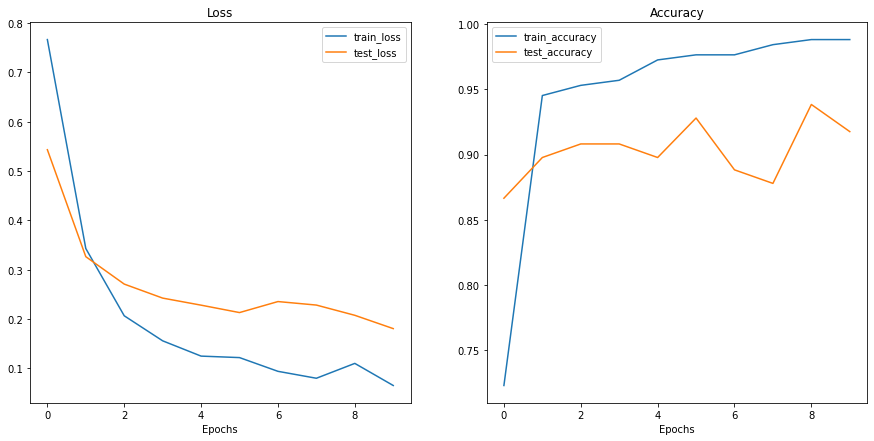

In [71]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [72]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [73]:
# load and test

from pathlib import Path

# bytes -> megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024**2)
pretrained_vit_model_size


# About stat module
# https://iq.opengenus.org/stat-module-python/#:~:text=Python's%20stat()%20module%20performs,and%20modified%20and%20much%20more.

327

# Final prediction

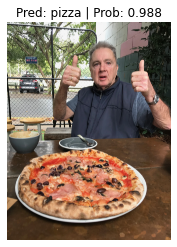

In [74]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_img_path = image_path / "04-pizza-dad.jpeg"

# Download the img if it doesn't already exist
if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as f:
        # For file downloading from github, it needs to have the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_img_path}...")
        f.write(request.content)
        
        
else:
    print(f"{custom_img_path} already exists, skpping download.")

    
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_img_path,
                    class_names=class_names)